In [21]:
import numpy as np
from chainer import Chain, dataset, Variable, cuda, functions, links, optimizer, optimizers, report, serializers, training
from chainer.training import extensions
from chainer import  using_config
from chainer.iterators import SerialIterator
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime as dt
import datetime

In [2]:
import sys
sys.path.append('C:/Users/tmatsumoto/AppData/code/seq2seq')
from predict_cryptcurrency import LSTM_coin, LossSumMSEOverTime

In [3]:
n_train = 10000

#学習用データの作成
csv_path = 'C:/Users/tmatsumoto/AppData/code/seq2seq/currency_data/BTCUSDT_1minutes_1year_1.csv'
coin_data = pd.read_csv(csv_path, encoding='UTF-8')

coin_data = coin_data.drop(coin_data.index[len(coin_data)-1])
#不要なカラムを削除
coin_data_ = coin_data.drop(["DATE"], axis=1)
coin_data_ = coin_data_.drop(coin_data_.index[:n_train])
#行列に変形
coin_data_matrix = coin_data_.as_matrix()

#学習データとテストデータに分解する
coin_data_all = coin_data_matrix

In [4]:
#データを正規化
scaler = MinMaxScaler()
yscaler = MinMaxScaler()
#minibatchの作成
batch_train = 3200
#    coin_data_batch = make_minibatch(coin_data_train, batch_size)

#データをinputとoutputに分解
coin_data_train = coin_data_all[:batch_train]

x_train = coin_data_train[:,:-1].astype(np.float32)
x_train = scaler.fit_transform(x_train)

y_train = coin_data_train[:,-1].reshape((-1,1)).astype(np.float32)
y_train = yscaler.fit_transform(y_train)

x_train = x_train[np.newaxis, :, :]
y_train = y_train[np.newaxis, :, :]

ds_train = list(zip(x_train, y_train))

coin_data_val = coin_data_all[batch_train:]

x_val = coin_data_val[:,:-1].astype(np.float32)
x_val = scaler.transform(x_val)

y_val = coin_data_val[:,-1].reshape((-1,1)).astype(np.float32)
y_val = yscaler.transform(y_val)

x_val = x_val[np.newaxis, :, :]
y_val = y_val[np.newaxis, :, :]


In [5]:
x_val.shape

(1, 1200, 84)

In [6]:
input_size = 84
hidden_size = 300
output_size = 1
FLAG_GPU = False

model = LossSumMSEOverTime(LSTM_coin(input_size=input_size,
                    embed_size=0,
                    hidden_size=hidden_size,
                    output_size=output_size,
                    flag_gpu=FLAG_GPU))

test_case = 'case10'
#model_path = 'C:/Users/tmatsumoto/AppData/code/seq2seq/predictor/BTC_predictor_' + test_case
model_path = 'C:/Users/tmatsumoto/AppData/code/seq2seq/result/model_snapshot_700'

In [7]:
serializers.load_npz(model_path, model)

In [8]:
model_ = model.predictor

In [9]:
model_.reset()
obs = np.concatenate((y_train, y_val), axis=1)[0]

# train data に関しては先ほどと同じく、観測値を使って予測し、
# 隠れ層の状態を作る。
pred = []
    
with using_config('train', False):
    for X_t in x_train[0]:
        p_t = model_(X_t.reshape(1,-1)).data[0]
        pred.append(p_t)

    for X_t in x_val[0]:
        p_t = model_(X_t.reshape(1,-1)).data[0]
        pred.append(p_t)

In [10]:
obs_unscale = yscaler.inverse_transform(obs)
pred_unscale = yscaler.inverse_transform(pred)

In [11]:
obs_data.shape

NameError: name 'obs_data' is not defined

In [12]:
obs_data = coin_data.drop(coin_data.index[:n_train])
obs_data = obs_data[["DATE","BTCUSDT_close_after_1min"]]
obs_data.reset_index(drop=True, inplace=True)

obs_data["USDT_BTC_close_after_5min_1"] = obs_unscale
obs_data["USDT_BTC_close_after_5min_pred"] = pred_unscale

In [13]:
obs_data.DATE = obs_data.DATE.apply(lambda x: dt.strptime(str(x), '%Y-%m-%d %H:%M:%S'))

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams
from matplotlib.ticker import *
%matplotlib inline

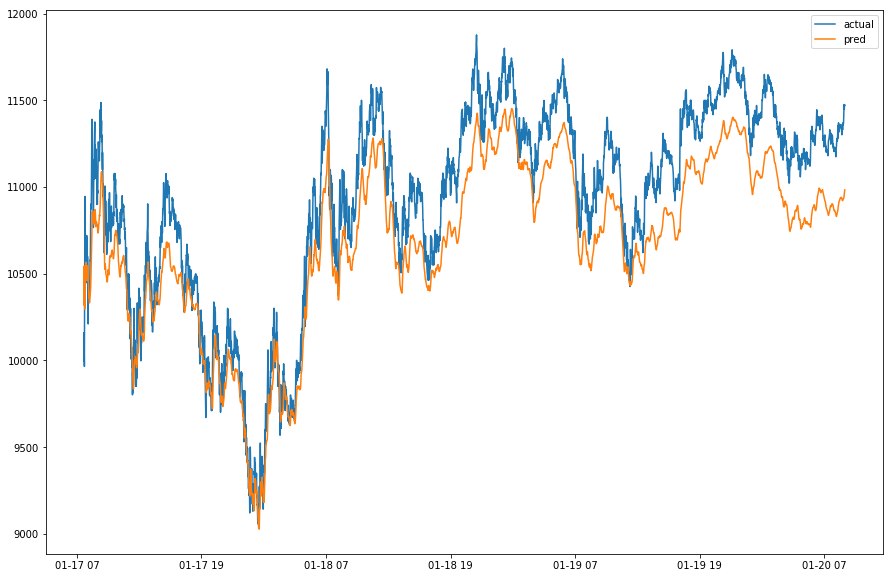

In [15]:
#学習期間の全データをプロット
plt.figure(figsize=(15,10))

plt.plot(obs_data["DATE"],obs_data["USDT_BTC_close_after_5min_1"], label='actual')
plt.plot(obs_data["DATE"],obs_data["USDT_BTC_close_after_5min_pred"], label='pred')

p = plt.legend()

In [17]:
#予測対象期間のみに絞る

date_border = obs_data.loc[3200].DATE
obs_data_pred = obs_data[obs_data.DATE >= date_border]

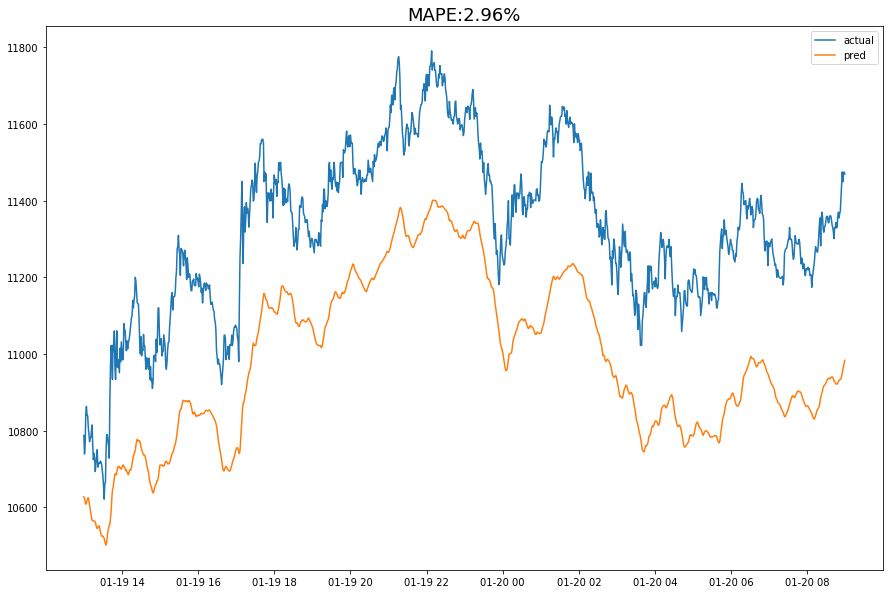

In [18]:
plt.figure(figsize=(15,10))

mape = (np.abs(obs_data_pred["BTCUSDT_close_after_1min"] - obs_data_pred["USDT_BTC_close_after_5min_pred"]) / obs_data_pred["BTCUSDT_close_after_1min"]).mean() * 100

plt.plot(obs_data_pred["DATE"],obs_data_pred["USDT_BTC_close_after_5min_1"], label='actual')
plt.plot(obs_data_pred["DATE"],obs_data_pred["USDT_BTC_close_after_5min_pred"], label='pred')

plt.title("MAPE:{1:.2f}%".format("", mape), fontsize=18)
p = plt.legend()

In [19]:
#データ加工用にdateをindex化
obs_data_pred2 = obs_data_pred.set_index(['DATE'])

#上がるか下がるかがどれだげ的中しているか算出
def get_diff(baseday, delta, diff_value, target_column):
    targetday = baseday - datetime.timedelta(minutes=delta)
    try:
        targetday_list = obs_data_pred2.loc[(targetday)]
    except:
        return np.NaN
    return 2 if (float(diff_value) - float(targetday_list[target_column])) > 0 else 1

In [22]:
delta = 5
obs_data_pred['USDT_BTC_close_after_5min_diff'] = obs_data_pred.apply(lambda x:get_diff(x.DATE, delta, x["USDT_BTC_close_after_5min_1"], "USDT_BTC_close_after_5min_1"), axis=1)
obs_data_pred['USDT_BTC_close_after_5min_pred_diff'] = obs_data_pred.apply(lambda x:get_diff(x.DATE, delta, x["USDT_BTC_close_after_5min_pred"], "USDT_BTC_close_after_5min_pred"), axis=1)

C:\Users\tmatsumoto\AppData\WinPython-64bit-3.5.4.0Qt5\python-3.5.4.amd64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\tmatsumoto\AppData\WinPython-64bit-3.5.4.0Qt5\python-3.5.4.amd64\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sn.heatmap(df_cmx, annot=True)
    plt.show()

In [26]:
obs_data_pred_3 = obs_data_pred.drop(obs_data_pred.index[0])
print_cmx(obs_data_pred_3['USDT_BTC_close_after_5min_diff'].tolist(),obs_data_pred_3['USDT_BTC_close_after_5min_pred_diff'].tolist())

ValueError: continuous is not supported

In [27]:
obs_data_pred_3

,DATE,BTCUSDT_close_after_1min,USDT_BTC_close_after_5min_1,USDT_BTC_close_after_5min_pred,USDT_BTC_close_after_5min_diff,USDT_BTC_close_after_5min_pred_diff
3201,2018-01-19 13:01:00,10738.80,10738.799805,10621.927755,NaN,NaN
3202,2018-01-19 13:02:00,10762.68,10762.679688,10612.994353,NaN,NaN
3203,2018-01-19 13:03:00,10842.46,10842.459961,10607.758276,NaN,NaN
3204,2018-01-19 13:04:00,10862.93,10862.929688,10610.229799,NaN,NaN
3205,2018-01-19 13:05:00,10839.90,10839.900391,10617.320784,2.0,1.0
3206,2018-01-19 13:06:00,10838.93,10838.929688,10623.025272,2.0,2.0
3207,2018-01-19 13:07:00,10808.75,10808.750000,10624.695179,2.0,2.0
3208,2018-01-19 13:08:00,10788.51,10788.509766,10616.415527,1.0,2.0
3209,2018-01-19 13:09:00,10770.95,10770.950195,10605.556828,1.0,1.0
3210,2018-01-19 13:10:00,10781.37,10781.370117,10595.212623,1.0,1.0
